In [1]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

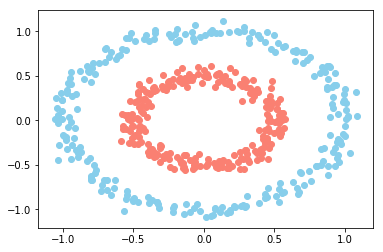

In [2]:
n = 500
p = 2

x, y = make_circles(n_samples=n, factor=0.5, noise=0.05)
y = y[:, np.newaxis]

plt.scatter(x[y[:,0] == 0,0], x[y[:,0] == 0,1], c='skyblue')
plt.scatter(x[y[:,0] == 1,0], x[y[:,0] == 1,1], c='salmon')
plt.show()

In [3]:
# Neural Layer
class NeuralLayer:
    def __init__(self, conn, neur, act_f):
        self.F = act_f
        self.B = (np.random.rand(1, neur)    * 2) - 1
        self.W = (np.random.rand(conn, neur) * 2) - 1

### Activation Functions
Sigmoide:\
$f(x) = \frac{1}{1 + \epsilon^{-x}} \;\;$ , $\frac{\partial f}{\partial x} = x\frac{1}{1-x}$

Hyperbolic Tangent:\
$f(x) = \frac{\epsilon^x - \epsilon^{-x}}{\epsilon^x + \epsilon^{-x}} \;$ , $\frac{\partial f}{\partial x} = \frac{1}{(\epsilon^x + \epsilon^{-x})^2}$

ReLU:\
$f(x) = \max(0, x) \;$ , $ \frac{\partial f}{\partial x} = \left\{\begin{array}{ll}
        1 & x>0\\
        0 & x \leq 0
    \end{array}\right.$

Linear:\
$f(x) = \frac{1}{1 + \epsilon^{-x}} \;$ , $ \frac{\partial f}{\partial x} = 1$

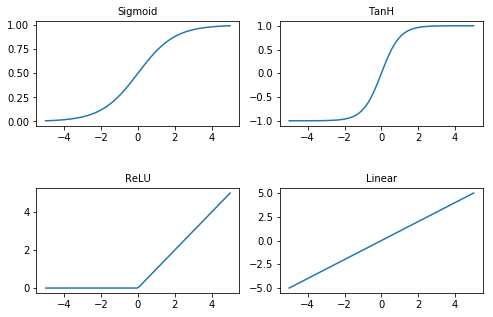

In [4]:
# Activation Functions
sigmf = (lambda x: 1 / (1 + np.power(np.e, -x)), lambda x: x * (1 - x))
tanhf = (lambda x: (np.power(np.e, x) - np.power(np.e, -x)) / (np.power(np.e, x) + np.power(np.e, -x)),
         lambda x: 1 / np.power(np.power(np.e, x) + np.power(np.e, -x),2))
reluf = (lambda x: np.maximum(0,x),              lambda x: [(1 if (v > 0) else 0) for v in x])
linef = (lambda x: x,                            lambda x: np.ones(len(x)))

tx = np.linspace(-5,5,100)

fig, axs = plt.subplots(2, 2, figsize=(8, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.2)

axs[0, 0].plot(tx, sigmf[0](tx))
axs[0, 0].set_title('Sigmoid',fontsize=10)

axs[0, 1].plot(tx, tanhf[0](tx))
axs[0, 1].set_title('TanH',fontsize=10)

axs[1, 0].plot(tx, reluf[0](tx))
axs[1, 0].set_title('ReLU',fontsize=10)

axs[1, 1].plot(tx, linef[0](tx))
axs[1, 1].set_title('Linear',fontsize=10)

plt.show()

In [5]:
# Loss Function (MSE)
lossf = (lambda yp, yr: np.mean(np.power(yp - yr, 2)),
         lambda yp, yr: (yp - yr))

In [6]:
# Hyper Parameters
topology = [p, 4, 8, 1]
functions = [sigmf, sigmf, sigmf]

### Partial Derivates
Output Layer Error:\
$\delta^{L} = \frac{\partial C}{\partial a^L} \cdot \frac{\partial a^L}{\partial z^L}$

Backpropagation of the Error to the Previous Layer:\
$\delta^{l-1} = W^{l} \delta^{l} \cdot \frac{\partial a^{l-1}}{\partial z^{l-1}}$

Calculate Derivatives of the Layer using the Error:\
$\frac{\partial C}{\partial b^{l-1}} = \delta^{l-1}\;$ , $\frac{\partial C}{\partial w^{l-1}} = \delta^{l-1}a^{l-2}$

In [11]:
# Neural Networ
class NeuralNetwork:
    def __init__(self, top, func):
        assert len(top)-1 == len(func), 'Top size = Func size + 1'
        
        self.nn = []
        self.topology = top
        
        for i in range(len(self.topology) - 1):
            self.nn.append(NeuralLayer(topology[i], topology[i+1], func[i]))
        
    def compile(self, loss, lr = 0.01):
        self.loss = loss
        self.lr = lr
        
    def forward(self, x, y):
        # (z, a)
        out = [(None, x)]
        
        for l, layer in enumerate(self.nn):
            z = (out[-1][1] @ self.nn[l].W) + self.nn[l].B
            a = self.nn[l].F[0](z)
            
            out.append((z, a))
        return out
    
    def backward(self, out):
        deltas = []
        
        for l in reversed(range(len(self.nn))):
            z = out[l+1][0]
            a = out[l+1][1]
            
            if(l == len(self.nn)-1):
                deltaL = self.loss[1](a, y) * self.nn[l].F[1](a)
                deltas.insert(0, deltaL)
            else:
                deltal1 = deltas[0] @ TW.T * self.nn[l].F[1](a)
                deltas.insert(0, deltal1)
                
            TW = self.nn[l].W
            
            # Gradient Descent
            self.nn[l].B = self.nn[l].B - np.mean(deltas[0], axis=0, keepdims=True) * self.lr
            self.nn[l].W = self.nn[l].W - out[l][1].T @ deltas[0] * self.lr
    
    def train(self, x, y):
        assert len(self.nn) > 0, 'Empty Neural Network'
        
        # Forward Pass
        out = self.forward(x,y)
        
        # Backward Pass
        self.backward(out)
        
        return out[-1][1]
    
    def fit(self, x, y, epoch=100):
        tloss = []
        trange = []
        
        for i in range(epoch):
            py = self.train(x,y)
            if(i%250 == 0):
                tl = self.loss[0](py, y)
                
                trange.append(i)
                tloss.append(tl)
                
                print('epoch {:4d}   => Loss: {:.4f} - Accuracy: {:.4f}'.format(i,tl,1-tl))
        
        plt.plot(trange, tloss, '.', c='red')                
        plt.show()
    
    def predict(self, x, y):
        return self.forward(x,y)[-1][1]
                                           
model = NeuralNetwork(topology, functions)
model.compile(lossf, lr=0.05)

epoch    0   => Loss: 0.2964 - Accuracy: 0.7036
epoch  250   => Loss: 0.1358 - Accuracy: 0.8642
epoch  500   => Loss: 0.0045 - Accuracy: 0.9955
epoch  750   => Loss: 0.0017 - Accuracy: 0.9983
epoch 1000   => Loss: 0.0010 - Accuracy: 0.9990
epoch 1250   => Loss: 0.0007 - Accuracy: 0.9993
epoch 1500   => Loss: 0.0006 - Accuracy: 0.9994
epoch 1750   => Loss: 0.0004 - Accuracy: 0.9996
epoch 2000   => Loss: 0.0004 - Accuracy: 0.9996
epoch 2250   => Loss: 0.0003 - Accuracy: 0.9997


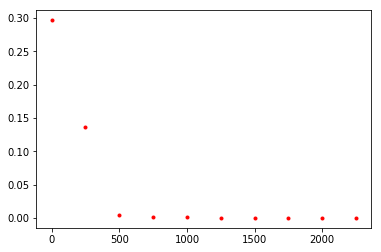

In [12]:
model.fit(x, y, epoch=2500)

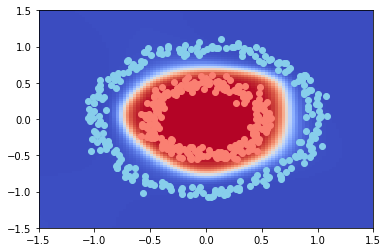

In [14]:
res = 100

_x0 = np.linspace(-1.5, 1.5, res)
_x1 = np.linspace(-1.5, 1.5, res)

_y = np.zeros((res, res))

for i0, x0 in enumerate(_x0):
    for i1, x1 in enumerate(_x1):
        py = model.predict(np.array([[x0, x1]]), y)
        _y[i0, i1] = py[0][0]

plt.pcolormesh(_x0, _x1, _y, cmap="coolwarm")

plt.scatter(x[y[:,0] == 0, 0], x[y[:,0] == 0, 1], c="skyblue")
plt.scatter(x[y[:,0] == 1, 0], x[y[:,0] == 1, 1], c="salmon")

plt.show()